In [1]:
import pandas as pd
import numpy as np
from numpy import std

import matplotlib.pyplot as plt
import datetime, time
from datetime import datetime

from google.cloud import bigquery

from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

from collections import Counter, defaultdict

from k_means_constrained import KMeansConstrained

np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
bqclient = bigquery.Client()
query_string = """
    SELECT 
      *
    FROM `ps-analytics-prod.markus.seller_segments_20230421`
"""
seller_base_df =  bqclient.query(query_string).result().to_dataframe()


seller_base_df.shape

(729, 328)

In [3]:
cols = ['shop_state', 'company_type', 'months_with_conrad', 'offers_active_mp_total', 'offers_active_mp_ict', 
        'offers_active_mp_mro', 'offers_active_mp_bssa', 'offers_inactive_mp_total', 
        'offers_inactive_mp_ict', 'offers_inactive_mp_mro', 'offers_inactive_mp_bssa', 
        'offers_active_oci_total', 'offers_active_oci_ict', 'offers_active_oci_mro', 
        'offers_active_oci_bssa', 'offers_inactive_oci_total', 'offers_inactive_oci_ict', 
        'offers_inactive_oci_mro', 'offers_inactive_oci_bssa', 
        'days_to_first_sale', 
        'sales_mp_1m_total', 'sales_mp_3m_total', 'sales_mp_6m_total', 'sales_mp_12m_total', 
        'sales_mp_12m_ict', 
        'sales_mp_12m_mro', 
        'sales_mp_12m_bssa', 
        'sales_oci_1m_total', 'sales_oci_3m_total', 'sales_oci_6m_total', 'sales_oci_12m_total', 
        'sales_oci_12m_ict', 
        'sales_oci_12m_mro', 
        'sales_oci_12m_bssa', 
        'pdp_active_1m_total', 'pdp_active_3m_total', 'pdp_active_6m_total', 'pdp_active_12m_total', 
        'pdp_active_12m_ict', 
        'pdp_active_12m_mro', 
        'pdp_active_12m_bssa', 
        'pdp_inactive_1m_total', 'pdp_inactive_3m_total', 'pdp_inactive_6m_total', 'pdp_inactive_12m_total', 
        'pdp_inactive_12m_ict', 
        'pdp_inactive_12m_mro', 
        'pdp_inactive_12m_bssa',
        'date_created', 'date_first_order']


In [4]:
seller_df = seller_base_df[cols].copy()
seller_df.shape, seller_base_df.shape

((729, 50), (729, 328))

In [5]:
#percentage of missing values in each variables
missing_features = []
for col in seller_df.columns:
    if (seller_df[col].isnull().sum() / len(seller_df[col]) * 100 > 0):
        missing_features.append(col)
missing_features

['days_to_first_sale', 'date_first_order']

In [6]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
non_numerics = ['object', 'boolean', 'dbdate']


numeric_df = seller_df.select_dtypes(include=numerics)
non_numerics_df = seller_df.select_dtypes(include=non_numerics)


for col in numeric_df.columns:
    numeric_df[col].replace({np.nan: 0}, inplace = True)


numeric_df.shape, seller_df.shape

/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


((729, 46), (729, 50))

In [7]:
seller_df.dtypes

shop_state                   object 
company_type                 object 
months_with_conrad           Int64  
offers_active_mp_total       Int64  
offers_active_mp_ict         Int64  
offers_active_mp_mro         Int64  
offers_active_mp_bssa        Int64  
offers_inactive_mp_total     Int64  
offers_inactive_mp_ict       Int64  
offers_inactive_mp_mro       Int64  
offers_inactive_mp_bssa      Int64  
offers_active_oci_total      Int64  
offers_active_oci_ict        Int64  
offers_active_oci_mro        Int64  
offers_active_oci_bssa       Int64  
offers_inactive_oci_total    Int64  
offers_inactive_oci_ict      Int64  
offers_inactive_oci_mro      Int64  
offers_inactive_oci_bssa     Int64  
days_to_first_sale           Int64  
sales_mp_1m_total            float64
sales_mp_3m_total            float64
sales_mp_6m_total            float64
sales_mp_12m_total           float64
sales_mp_12m_ict             float64
sales_mp_12m_mro             float64
sales_mp_12m_bssa            float64
s

In [8]:
#Normalize data
normalized = normalize(numeric_df)
data_Scaled = pd.DataFrame(normalized)

In [9]:
#Storing the data variance and name of variables
variance = data_Scaled.var()
columns = numeric_df.columns

In [10]:
#Saving the names of variables having variance mre than a threshold value
variables = []
variance_threshold = 0.0001 #Setting threshold as 0.001
for i in range(0, len(variance)):
    if variance[i]> variance_threshold:
        variables.append(columns[i])

In [11]:
len(variables)

39

In [12]:
non_numerics_col_list = non_numerics_df.columns

In [13]:
len(variables), len(columns), len(non_numerics_col_list)

(39, 46, 4)

In [14]:
#col_list = non_numerics_col_list + variables
for x in non_numerics_col_list:
    variables.append(x)
len(variables)

43

In [15]:
#Creating new data frame with using the variables above
seller_df = seller_df[variables]
seller_df.shape

(729, 43)

In [16]:
seller_df = pd.concat([seller_df, pd.get_dummies(seller_df["shop_state"],prefix="shop_state_cat")], axis=1)
seller_df.drop(columns=["shop_state"], axis=1, inplace=True)

seller_df.head()

,months_with_conrad,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_inactive_mp_total,offers_inactive_mp_ict,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_active_oci_total,offers_active_oci_mro,days_to_first_sale,sales_mp_1m_total,sales_mp_3m_total,sales_mp_6m_total,sales_mp_12m_total,sales_mp_12m_ict,sales_mp_12m_mro,sales_mp_12m_bssa,sales_oci_3m_total,sales_oci_6m_total,sales_oci_12m_total,sales_oci_12m_ict,sales_oci_12m_mro,sales_oci_12m_bssa,pdp_active_1m_total,pdp_active_3m_total,pdp_active_6m_total,pdp_active_12m_total,pdp_active_12m_ict,pdp_active_12m_mro,pdp_active_12m_bssa,pdp_inactive_1m_total,pdp_inactive_3m_total,pdp_inactive_6m_total,pdp_inactive_12m_total,pdp_inactive_12m_ict,pdp_inactive_12m_mro,pdp_inactive_12m_bssa,company_type,date_created,date_first_order,shop_state_cat_CLOSE,shop_state_cat_OPEN,shop_state_cat_SUSPENDED
0,39,0,0,0,0,1,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Co. KG,2020-01-08,NaT,0,0,1
1,57,0,0,0,0,505977,10,18156,487633,0,0,49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,833,2931,7998,13411,1,1413,11997,other,2018-07-27,2018-09-14,0,0,1
2,24,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,GmbH,2021-04-28,NaT,0,0,1
3,7,0,0,0,0,2,0,0,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,17,17,19,19,0,0,19,Co. KG,2022-09-07,NaT,0,0,1
4,25,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Co. KG,2021-03-26,NaT,0,0,1


In [17]:
seller_df.days_to_first_sale.min(), seller_df.days_to_first_sale.mean(), seller_df.days_to_first_sale.max(), std(seller_df.days_to_first_sale)


(0, 97.11659807956104, 1375, 149.09485058422194)

<AxesSubplot:>

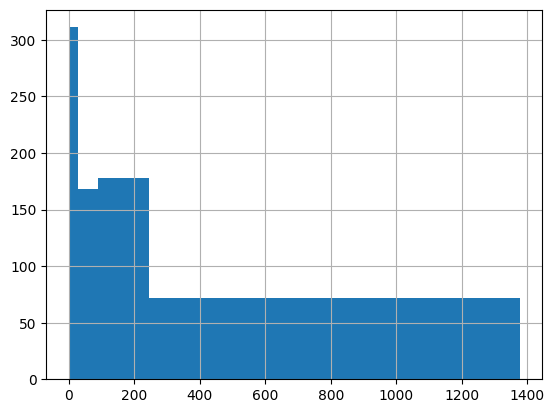

In [18]:
days_to_first_sale_bins = [seller_df.days_to_first_sale.min() ,30 ,90, seller_df.days_to_first_sale.mean() + std(seller_df.days_to_first_sale), seller_df.days_to_first_sale.max() +1 ]
seller_df.days_to_first_sale.hist(bins=days_to_first_sale_bins)


In [19]:
days_to_first_sale_bins

[0, 30, 90, 246.211448663783, 1376]

In [20]:
seller_df.days_to_first_sale.value_counts(bins=days_to_first_sale_bins)

(-0.001, 30.0]       314
(90.0, 246.211]      175
(30.0, 90.0]         168
(246.211, 1376.0]    72 
Name: days_to_first_sale, dtype: int64

In [21]:
seller_df['days_to_first_sale'] = pd.cut(seller_df.days_to_first_sale, days_to_first_sale_bins).cat.codes
seller_df['days_to_first_sale'].value_counts()

-1    232
 2    175
 1    168
 0    82 
 3    72 
Name: days_to_first_sale, dtype: int64

In [22]:
company_type_dictionary = dict(zip(seller_df['company_type'].unique() , np.arange(1, len(seller_df['company_type'].unique()) + 1, 1).tolist()))
seller_df['company_type'] = seller_df['company_type'].map(company_type_dictionary)
seller_df['company_type'].nunique()

4

In [23]:
for col in seller_df.select_dtypes(include=['dbdate']).columns:
    print(col)
    seller_df[col].replace({np.nan: '1999-01-01'}, inplace = True)
    seller_df[col] = pd.to_datetime(seller_df[col])

date_created
date_first_order


In [24]:
seller_df["date_created_day"] = seller_df['date_created'].map(lambda x: x.day)
seller_df["date_created_month"] = seller_df['date_created'].map(lambda x: x.month)
seller_df["date_created_year"] = seller_df['date_created'].map(lambda x: x.year)
seller_df.drop(columns=["date_created"], axis=1, inplace=True)
##############
seller_df["date_first_order_day"] = seller_df['date_first_order'].map(lambda x: x.day)
seller_df["date_first_order_month"] = seller_df['date_first_order'].map(lambda x: x.month)
seller_df["date_first_order_year"] = seller_df['date_first_order'].map(lambda x: x.year)
seller_df.drop(columns=["date_first_order"], axis=1, inplace=True)

In [25]:
seller_df.head()

,months_with_conrad,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_inactive_mp_total,offers_inactive_mp_ict,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_active_oci_total,offers_active_oci_mro,days_to_first_sale,sales_mp_1m_total,sales_mp_3m_total,sales_mp_6m_total,sales_mp_12m_total,sales_mp_12m_ict,sales_mp_12m_mro,sales_mp_12m_bssa,sales_oci_3m_total,sales_oci_6m_total,sales_oci_12m_total,sales_oci_12m_ict,sales_oci_12m_mro,sales_oci_12m_bssa,pdp_active_1m_total,pdp_active_3m_total,pdp_active_6m_total,pdp_active_12m_total,pdp_active_12m_ict,pdp_active_12m_mro,pdp_active_12m_bssa,pdp_inactive_1m_total,pdp_inactive_3m_total,pdp_inactive_6m_total,pdp_inactive_12m_total,pdp_inactive_12m_ict,pdp_inactive_12m_mro,pdp_inactive_12m_bssa,company_type,shop_state_cat_CLOSE,shop_state_cat_OPEN,shop_state_cat_SUSPENDED,date_created_day,date_created_month,date_created_year,date_first_order_day,date_first_order_month,date_first_order_year
0,39,0,0,0,0,1,0,1,0,0,0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,8,1,2020,1,1,1999
1,57,0,0,0,0,505977,10,18156,487633,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,833,2931,7998,13411,1,1413,11997,2,0,0,1,27,7,2018,14,9,2018
2,24,0,0,0,0,0,0,0,0,0,0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,28,4,2021,1,1,1999
3,7,0,0,0,0,2,0,0,2,0,0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,17,17,19,19,0,0,19,1,0,0,1,7,9,2022,1,1,1999
4,25,0,0,0,0,0,0,0,0,0,0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,26,3,2021,1,1,1999


In [26]:
class color:
   BOLD = '\033[1m'
   END = '\033[0m'

In [27]:
seller_df.columns

Index(['months_with_conrad', 'offers_active_mp_total', 'offers_active_mp_ict',
       'offers_active_mp_mro', 'offers_active_mp_bssa',
       'offers_inactive_mp_total', 'offers_inactive_mp_ict',
       'offers_inactive_mp_mro', 'offers_inactive_mp_bssa',
       'offers_active_oci_total', 'offers_active_oci_mro',
       'days_to_first_sale', 'sales_mp_1m_total', 'sales_mp_3m_total',
       'sales_mp_6m_total', 'sales_mp_12m_total', 'sales_mp_12m_ict',
       'sales_mp_12m_mro', 'sales_mp_12m_bssa', 'sales_oci_3m_total',
       'sales_oci_6m_total', 'sales_oci_12m_total', 'sales_oci_12m_ict',
       'sales_oci_12m_mro', 'sales_oci_12m_bssa', 'pdp_active_1m_total',
       'pdp_active_3m_total', 'pdp_active_6m_total', 'pdp_active_12m_total',
       'pdp_active_12m_ict', 'pdp_active_12m_mro', 'pdp_active_12m_bssa',
       'pdp_inactive_1m_total', 'pdp_inactive_3m_total',
       'pdp_inactive_6m_total', 'pdp_inactive_12m_total',
       'pdp_inactive_12m_ict', 'pdp_inactive_12m_mro', 'pdp_in

In [28]:
periodic_cols = ['sales_mp_1m_total', 'sales_mp_3m_total', 
                 'sales_mp_6m_total', 'sales_mp_12m_total', 'sales_mp_12m_ict', 
                 'sales_mp_12m_mro', 'sales_mp_12m_bssa', 'sales_oci_3m_total', 
                 'sales_oci_6m_total', 'sales_oci_12m_total', 'sales_oci_12m_ict', 
                 'sales_oci_12m_mro', 'sales_oci_12m_bssa', 'pdp_active_1m_total', 
                 'pdp_active_3m_total', 'pdp_active_6m_total', 'pdp_active_12m_total', 
                 'pdp_active_12m_ict', 'pdp_active_12m_mro', 'pdp_active_12m_bssa', 
                 'pdp_inactive_1m_total', 'pdp_inactive_3m_total', 
                 'pdp_inactive_6m_total', 'pdp_inactive_12m_total', 
                 'pdp_inactive_12m_ict', 'pdp_inactive_12m_mro', 'pdp_inactive_12m_bssa']
offer_cols = ['offers_active_mp_total', 'offers_active_mp_ict', 
              'offers_active_mp_mro', 'offers_active_mp_bssa', 
              'offers_inactive_mp_total', 'offers_inactive_mp_ict', 
              'offers_inactive_mp_mro', 'offers_inactive_mp_bssa', 
              'offers_active_oci_total', 'offers_active_oci_mro']

sales_mp_1m_total
sales_mp_3m_total
sales_mp_6m_total
sales_mp_12m_total
sales_mp_12m_ict
sales_mp_12m_mro
sales_mp_12m_bssa
sales_oci_3m_total
sales_oci_6m_total
sales_oci_12m_total
sales_oci_12m_ict
sales_oci_12m_mro
sales_oci_12m_bssa
pdp_active_1m_total
pdp_active_3m_total
pdp_active_6m_total
pdp_active_12m_total
pdp_active_12m_ict
pdp_active_12m_mro
pdp_active_12m_bssa
pdp_inactive_1m_total
pdp_inactive_3m_total
pdp_inactive_6m_total
pdp_inactive_12m_total
pdp_inactive_12m_ict
pdp_inactive_12m_mro
pdp_inactive_12m_bssa
CPU times: user 199 ms, sys: 7.26 ms, total: 206 ms
Wall time: 201 ms


,months_with_conrad,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_inactive_mp_total,offers_inactive_mp_ict,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_active_oci_total,offers_active_oci_mro,days_to_first_sale,sales_mp_1m_total,sales_mp_3m_total,sales_mp_6m_total,sales_mp_12m_total,sales_mp_12m_ict,sales_mp_12m_mro,sales_mp_12m_bssa,sales_oci_3m_total,sales_oci_6m_total,sales_oci_12m_total,sales_oci_12m_ict,sales_oci_12m_mro,sales_oci_12m_bssa,pdp_active_1m_total,pdp_active_3m_total,pdp_active_6m_total,pdp_active_12m_total,pdp_active_12m_ict,pdp_active_12m_mro,pdp_active_12m_bssa,pdp_inactive_1m_total,pdp_inactive_3m_total,pdp_inactive_6m_total,pdp_inactive_12m_total,pdp_inactive_12m_ict,pdp_inactive_12m_mro,pdp_inactive_12m_bssa,company_type,shop_state_cat_CLOSE,shop_state_cat_OPEN,shop_state_cat_SUSPENDED,date_created_day,date_created_month,date_created_year,date_first_order_day,date_first_order_month,date_first_order_year
0,39,0,0,0,0,1,0,1,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,0,1,8,1,2020,1,1,1999
1,57,0,0,0,0,505977,10,18156,487633,0,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,0,1,1,2,0,0,1,27,7,2018,14,9,2018
2,24,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,0,0,1,28,4,2021,1,1,1999
3,7,0,0,0,0,2,0,0,2,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,-1,-1,1,1,0,0,1,7,9,2022,1,1,1999
4,25,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,0,1,26,3,2021,1,1,1999


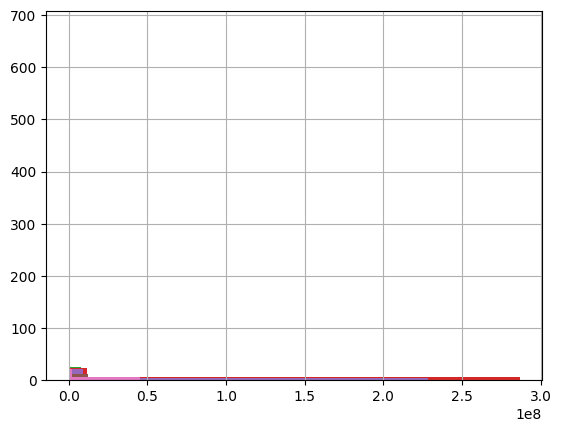

In [29]:
%%time
for col in periodic_cols:
    print(col)
    offer_bins = [seller_df[col].min(),1, seller_df[col].mean(), seller_df[col].mean() + std(seller_df[col]), seller_df[col].max() +1 ]
    seller_df[col].hist(bins=offer_bins)
    seller_df[col] = pd.cut(seller_df[col], offer_bins).cat.codes
seller_df.head()


In [30]:
offer_cols

['offers_active_mp_total',
 'offers_active_mp_ict',
 'offers_active_mp_mro',
 'offers_active_mp_bssa',
 'offers_inactive_mp_total',
 'offers_inactive_mp_ict',
 'offers_inactive_mp_mro',
 'offers_inactive_mp_bssa',
 'offers_active_oci_total',
 'offers_active_oci_mro']

In [31]:
seller_df.offers_active_mp_total.min(), seller_df.offers_active_mp_total.mean(), seller_df.offers_active_mp_total.max(), std(seller_df.offers_active_mp_total)


(0, 10820.958847736625, 550065, 48818.11086754533)

<AxesSubplot:>

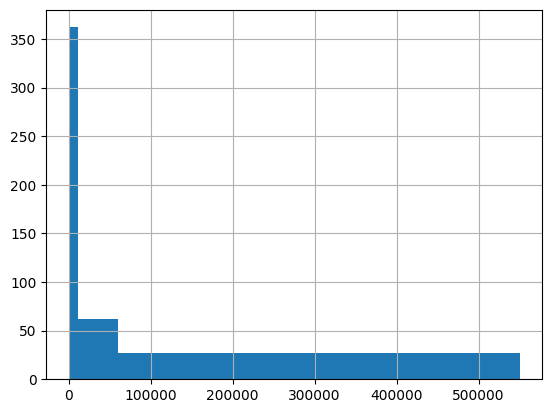

In [32]:
offers_active_mp_total_bins = [seller_df.offers_active_mp_total.min(),1 , seller_df.offers_active_mp_total.mean(), seller_df.offers_active_mp_total.mean() + std(seller_df.offers_active_mp_total), seller_df.offers_active_mp_total.max() +1 ]
seller_df.offers_active_mp_total.hist(bins=offers_active_mp_total_bins)

In [33]:
seller_df.offers_active_mp_total.value_counts(bins=offers_active_mp_total_bins)

(1.0, 10820.959]         349
(-0.001, 1.0]            291
(10820.959, 59639.07]    62 
(59639.07, 550066.0]     27 
Name: offers_active_mp_total, dtype: int64

offers_active_mp_total
offers_active_mp_ict
offers_active_mp_mro
offers_active_mp_bssa
offers_inactive_mp_total
offers_inactive_mp_ict
offers_inactive_mp_mro
offers_inactive_mp_bssa
offers_active_oci_total
offers_active_oci_mro
CPU times: user 96.7 ms, sys: 0 ns, total: 96.7 ms
Wall time: 89.6 ms


,months_with_conrad,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_inactive_mp_total,offers_inactive_mp_ict,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_active_oci_total,offers_active_oci_mro,days_to_first_sale,sales_mp_1m_total,sales_mp_3m_total,sales_mp_6m_total,sales_mp_12m_total,sales_mp_12m_ict,sales_mp_12m_mro,sales_mp_12m_bssa,sales_oci_3m_total,sales_oci_6m_total,sales_oci_12m_total,sales_oci_12m_ict,sales_oci_12m_mro,sales_oci_12m_bssa,pdp_active_1m_total,pdp_active_3m_total,pdp_active_6m_total,pdp_active_12m_total,pdp_active_12m_ict,pdp_active_12m_mro,pdp_active_12m_bssa,pdp_inactive_1m_total,pdp_inactive_3m_total,pdp_inactive_6m_total,pdp_inactive_12m_total,pdp_inactive_12m_ict,pdp_inactive_12m_mro,pdp_inactive_12m_bssa,company_type,shop_state_cat_CLOSE,shop_state_cat_OPEN,shop_state_cat_SUSPENDED,date_created_day,date_created_month,date_created_year,date_first_order_day,date_first_order_month,date_first_order_year
0,39,-1,-1,-1,-1,0,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,0,1,8,1,2020,1,1,1999
1,57,-1,-1,-1,-1,2,1,2,3,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,0,1,1,2,0,0,1,27,7,2018,14,9,2018
2,24,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,0,0,1,28,4,2021,1,1,1999
3,7,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,-1,-1,1,1,0,0,1,7,9,2022,1,1,1999
4,25,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,0,1,26,3,2021,1,1,1999


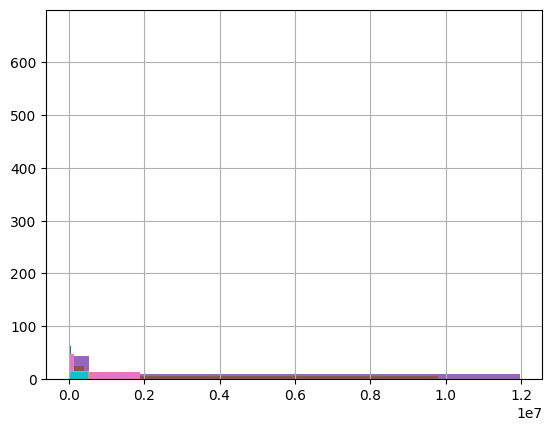

In [34]:
%%time
for col in offer_cols:
    print(col)
    offer_bins = [seller_df[col].min(),1 , seller_df[col].mean(), seller_df[col].mean() + std(seller_df[col]), seller_df[col].max() +1 ]
    seller_df[col].hist(bins=offer_bins)
    seller_df[col] = pd.cut(seller_df[col], offer_bins).cat.codes
seller_df.head()

In [39]:
K = range(5,12)

In [43]:
for k in K:
    clf = KMeansConstrained(
             n_clusters=k,
             size_min=20,
             size_max=200,
             random_state=100
    )
    clf.fit_predict(seller_df)
    #print(color.BOLD + str(k) + color.END)
    print(Counter(clf.labels_))
    silhouette_avg_kmeans = silhouette_score(seller_df, clf.labels_)
    print(color.BOLD + "For n_clusters =", str(clf.labels_.max() + 1) + color.END, "The average silhouette_score is :", silhouette_avg_kmeans)

Counter({0: 200, 4: 191, 2: 137, 1: 108, 3: 93})
For n_clusters = 5 The average silhouette_score is : 0.27208518712381413
Counter({0: 179, 1: 135, 3: 116, 2: 104, 4: 100, 5: 95})
For n_clusters = 6 The average silhouette_score is : 0.26112851504264073
Counter({1: 136, 2: 116, 5: 105, 3: 99, 4: 93, 0: 93, 6: 87})
For n_clusters = 7 The average silhouette_score is : 0.2528980507759034
Counter({4: 108, 1: 101, 2: 98, 5: 98, 6: 94, 7: 81, 0: 77, 3: 72})
For n_clusters = 8 The average silhouette_score is : 0.2437297282119155
Counter({5: 115, 6: 88, 4: 84, 1: 82, 7: 79, 0: 77, 8: 72, 3: 66, 2: 66})
For n_clusters = 9 The average silhouette_score is : 0.23914976040106603
Counter({2: 87, 4: 85, 8: 83, 6: 80, 5: 73, 0: 67, 1: 64, 3: 64, 9: 63, 7: 63})
For n_clusters = 10 The average silhouette_score is : 0.2320624911549755
Counter({0: 84, 1: 83, 3: 80, 4: 80, 8: 72, 5: 66, 2: 65, 10: 56, 7: 53, 9: 45, 6: 45})
For n_clusters = 11 The average silhouette_score is : 0.23202370070468523


In [44]:
clf_5 = KMeansConstrained(
             n_clusters=5,
             size_min=20,
             size_max=200,
             random_state=100
)
clf_5.fit_predict(seller_df)
#print(color.BOLD + str(k) + color.END)
print(Counter(clf_5.labels_))
silhouette_avg_kmeans = silhouette_score(seller_df, clf_5.labels_)
print(color.BOLD + "For n_clusters =", str(clf_5.labels_.max() + 1) + color.END, "The average silhouette_score is :", silhouette_avg_kmeans)

Counter({0: 200, 4: 191, 2: 137, 1: 108, 3: 93})
For n_clusters = 5 The average silhouette_score is : 0.27208518712381413


In [45]:
clf_6 = KMeansConstrained(
             n_clusters=6,
             size_min=20,
             size_max=200,
             random_state=100
)
clf_6.fit_predict(seller_df)
#print(color.BOLD + str(k) + color.END)
print(Counter(clf_6.labels_))
silhouette_avg_kmeans = silhouette_score(seller_df, clf_6.labels_)
print(color.BOLD + "For n_clusters =", str(clf_6.labels_.max() + 1) + color.END, "The average silhouette_score is :", silhouette_avg_kmeans)

Counter({0: 179, 1: 135, 3: 116, 2: 104, 4: 100, 5: 95})
For n_clusters = 6 The average silhouette_score is : 0.26112851504264073


In [46]:
clf_7 = KMeansConstrained(
             n_clusters=7,
             size_min=20,
             size_max=200,
             random_state=100
)
clf_7.fit_predict(seller_df)
#print(color.BOLD + str(k) + color.END)
print(Counter(clf_7.labels_))
silhouette_avg_kmeans = silhouette_score(seller_df, clf_7.labels_)
print(color.BOLD + "For n_clusters =", str(clf_7.labels_.max() + 1) + color.END, "The average silhouette_score is :", silhouette_avg_kmeans)

Counter({1: 136, 2: 116, 5: 105, 3: 99, 4: 93, 0: 93, 6: 87})
For n_clusters = 7 The average silhouette_score is : 0.2528980507759034


In [47]:
#seller_base_df['seller_segments'] = clf.labels_
seller_df_5 = seller_base_df.copy()
loc = clf_5.labels_

seller_df_6 = seller_base_df.copy()
seller_df_6['seller_segments'] = clf_6.labels_

seller_df_7 = seller_base_df.copy()
seller_df_7['seller_segments'] = clf_7.labels_



/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

In [66]:
np.savetxt(r'dataset/clf_5_centroids.txt', clf_5.cluster_centers_, fmt='%10.5f')
np.savetxt(r'dataset/clf_6_centroids.txt', clf_6.cluster_centers_, fmt='%10.5f')
np.savetxt(r'dataset/clf_7_centroids.txt', clf_7.cluster_centers_, fmt='%10.5f')

In [67]:
# TODO(developer): Set table_id to the ID of the table to fetch.

table_id_5 = 'ps-analytics-prod.eser.seller_segment_results_iteration_4_k_5'
table_id_6 = 'ps-analytics-prod.eser.seller_segment_results_iteration_4_k_6'
table_id_7 = 'ps-analytics-prod.eser.seller_segment_results_iteration_4_k_7'

table_list = [table_id_5, table_id_6, table_id_7]
seller_list = [seller_df_5, seller_df_6, seller_df_7]

for table in table_list:
    bqclient.delete_table(table, not_found_ok=True)  # Make an API request.
    print("Deleted table '{}'.".format(table))
    
# Load data to BQ
job = bqclient.load_table_from_dataframe(seller_df_5, table_id_5)
print("Table created '{}'.".format(table_id_5))

job = bqclient.load_table_from_dataframe(seller_df_6, table_id_6)
print("Table created '{}'.".format(table_id_6))

job = bqclient.load_table_from_dataframe(seller_df_7, table_id_7)
print("Table created '{}'.".format(table_id_7))

Deleted table 'ps-analytics-prod.eser.seller_segment_results_iteration_4_k_5'.
Deleted table 'ps-analytics-prod.eser.seller_segment_results_iteration_4_k_6'.
Deleted table 'ps-analytics-prod.eser.seller_segment_results_iteration_4_k_7'.


/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/google/cloud/bigquery/_pandas_helpers.py:484: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  sample_data = _first_valid(dataframe.reset_index()[column])
/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/google/cloud/bigquery/_pandas_helpers.py:547: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  arrow_table = pyarrow.array(dataframe.reset_index()[field.name])


Table created 'ps-analytics-prod.eser.seller_segment_results_iteration_4_k_5'.
Table created 'ps-analytics-prod.eser.seller_segment_results_iteration_4_k_6'.
Table created 'ps-analytics-prod.eser.seller_segment_results_iteration_4_k_7'.


In [68]:
seller_df.columns

Index(['months_with_conrad', 'offers_active_mp_total', 'offers_active_mp_ict',
       'offers_active_mp_mro', 'offers_active_mp_bssa',
       'offers_inactive_mp_total', 'offers_inactive_mp_ict',
       'offers_inactive_mp_mro', 'offers_inactive_mp_bssa',
       'offers_active_oci_total', 'offers_active_oci_mro',
       'days_to_first_sale', 'sales_mp_1m_total', 'sales_mp_3m_total',
       'sales_mp_6m_total', 'sales_mp_12m_total', 'sales_mp_12m_ict',
       'sales_mp_12m_mro', 'sales_mp_12m_bssa', 'sales_oci_3m_total',
       'sales_oci_6m_total', 'sales_oci_12m_total', 'sales_oci_12m_ict',
       'sales_oci_12m_mro', 'sales_oci_12m_bssa', 'pdp_active_1m_total',
       'pdp_active_3m_total', 'pdp_active_6m_total', 'pdp_active_12m_total',
       'pdp_active_12m_ict', 'pdp_active_12m_mro', 'pdp_active_12m_bssa',
       'pdp_inactive_1m_total', 'pdp_inactive_3m_total',
       'pdp_inactive_6m_total', 'pdp_inactive_12m_total',
       'pdp_inactive_12m_ict', 'pdp_inactive_12m_mro', 'pdp_in